In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise

image = cv2.imread("/content/drive/MyDrive/images/testest.png")
image = cv2.resize(image, (700, 525)) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [ ]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	# if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
	if (w >= 25 and w <= 150) and (h >= 40 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)
   
   # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [ ]:
model = load_model("/content/drive/MyDrive/model/model_new.model")
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [ ]:
def return_flag(y, h):
  if(abs(y-first)>int(2*h)):
      print("Third Line")
      print(abs(y-first))
      print(2*(0.5 * h))
      flag = 2
  elif(abs(y-first)> int(h)):
      print("Second Line\t")
      print(abs(y-first))
      print((0.5 * h))
      flag = 1
  else:
      print("First Line")
      flag = 0
  return flag

First Line
[INFO] F - 34.67%
Third Line
292
74.0
[INFO] P - 65.92%
Second Line	
143
46.0
[INFO] Y - 97.43%
First Line
[INFO] 7 - 49.83%
Third Line
292
77.0
[INFO] R - 98.00%
Second Line	
147
43.0
[INFO] E - 74.57%
First Line
[INFO] N - 62.86%
First Line
[INFO] V - 99.14%
Third Line
286
84.0
[INFO] 0 - 52.20%
Second Line	
149
40.0
[INFO] A - 98.15%
First Line
[INFO] A - 64.81%
Second Line	
144
41.0
[INFO] R - 98.50%
Third Line
285
76.0
[INFO] J - 80.46%
First Line
[INFO] L - 98.84%
Third Line
283
77.0
[INFO] E - 92.08%
Third Line
286
74.0
[INFO] C - 99.49%
Third Line
283
78.0
[INFO] T - 43.76%


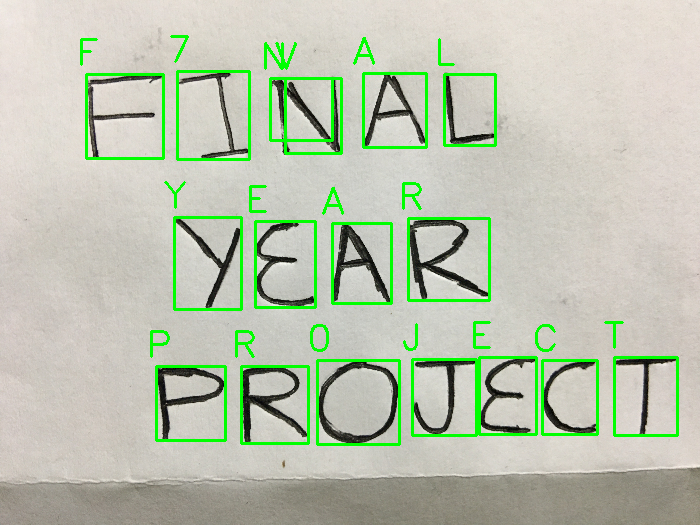

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1

In [ ]:
# add logic of eliminating letters if they co-incide
from google.colab import files
index = 0
rows, cols = (4, 0)
out = [[0 for i in range(cols)] for j in range(rows)]
value_x = [[0 for i in range(cols)] for j in range(rows)]
from google.colab.patches import cv2_imshow
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    if index == 0:
      first = y
      width = w;
    index+=1
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]

   # print(f"X= {x} \tY= {y} \tW= {w} \tH={h}")

    ret = return_flag(y, h)
    out[ret].append(label)
    value_x[ret].append(x)
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

# show the image
cv2_imshow(image)
cv2.imwrite('image.jpg',image)
files.download('image.jpg')
cv2.waitKey(0)


In [ ]:
# ans = ''
# print(out)
# print(value_x)
# for val in value_x[0]:
#     print(val)
# for row in out:
#   listToStr = ''.join([str(elem) for elem in row]) 
#   ans+=listToStr+"\n"
# print(ans)

In [ ]:
def detect_space():
  ans = ''
  i=0
  j=0
  for row in out:
    if not row:
      break;
    j=0;
    for elem in row:
      if(j==0):
        space_index = value_x[i][0]
        listToStr=''.join(str(elem))
      else:
        if (value_x[i][j] - space_index) > width*1.5: # 200 is the minimum space distance
          listToStr+='  '+str(elem)
        else:
          listToStr+=''.join(str(elem))
        space_index = value_x[i][j]
      j+=1
    ans+=listToStr+"\n"
    i+=1
  print(ans)
detect_space()

F7NVAL
YEAR
PR0JECT

